In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.decomposition import PCA, FastICA

from matplotlib import colors

from time import perf_counter

import umap

from utilities import get_reconstruction_error, get_pca_components_for_var, df_to_heatmap, get_max_along_df_axis

In [25]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40]

In [21]:
# Import shared settings
from settings import random_state, n_jobs, nSamples, max_iter, test_size, class_sep
# Override settings
#...

In [22]:
# Used for plot names
dim_red_name = "umap"
casename = f"synthetic_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Generate Data

In [23]:
X_full, y_full = make_classification(n_samples=nSamples, n_features=40, n_informative=10, n_redundant=5, n_classes=6, random_state=random_state, class_sep=class_sep)

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print("Fraction of training data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')

print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print("Fraction of testing data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')


X.shape = (2000, 40)
y.shape = (2000,)
Fraction of training data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665

X_test.shape = (500, 40)
y_test.shape = (500,)
Fraction of testing data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665


In [52]:
a = np.random.rand(5, 4)

In [53]:
a

array([[0.72100597, 0.0396962 , 0.98038539, 0.13572972],
       [0.49084529, 0.82860941, 0.96348496, 0.12952785],
       [0.48864069, 0.97894444, 0.73530894, 0.40254809],
       [0.46829299, 0.62473901, 0.47581287, 0.4512551 ],
       [0.06132069, 0.60556417, 0.47953573, 0.45964158]])

In [55]:
a.take([1, 3, 2], axis=0)

array([[0.49084529, 0.82860941, 0.96348496, 0.12952785],
       [0.46829299, 0.62473901, 0.47581287, 0.4512551 ],
       [0.48864069, 0.97894444, 0.73530894, 0.40254809]])

# Reconstruction Error

In [48]:
# n_components = [2, 3, 4, 5, 7, 10, 13, 15, 20, 25, 30, 35, 40]
reconstruction_error = np.zeros(len(n_components))
for i, this_n in enumerate(n_components):
    pipe_reconstruction = Pipeline([('scaler', StandardScaler()), 
                                       (f'{dim_red_name}', umap.UMAP(n_neighbors=5, n_components=this_n, random_state=random_state))])
    pipe_reconstruction.fit(X)
    reconstruction_error[i] = get_reconstruction_error(X, pipe_reconstruction)
joblib.dump(reconstruction_error, f'{casename}_reconstruction_error.pkl')

AttributeError: 'UMAP' object has no attribute 'inverse_transform'

# UMAP for Visualization

n_neighbors = 2


C:\Users\Scribs\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 237 separate connected components using meta-embedding (experimental)
  n_components


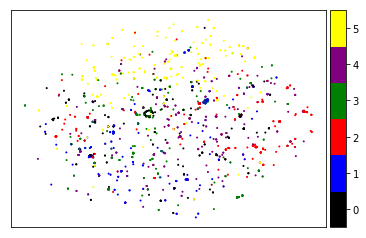

n_neighbors = 3


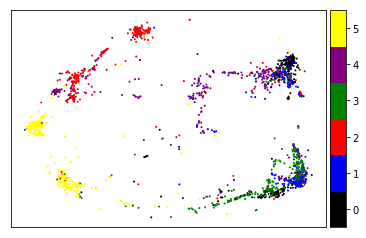

n_neighbors = 5


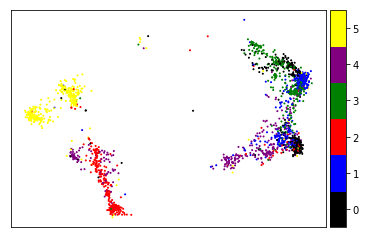

n_neighbors = 7


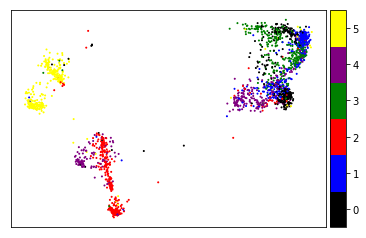

n_neighbors = 10


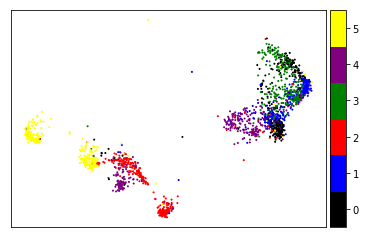

n_neighbors = 15


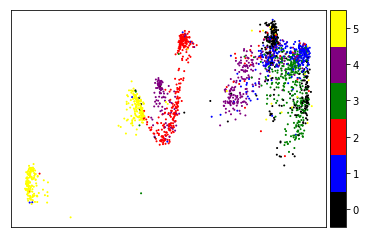

n_neighbors = 20


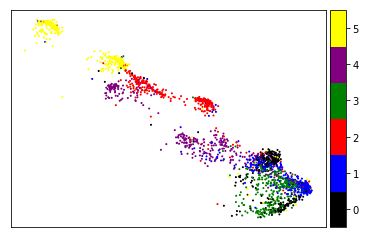

n_neighbors = 30


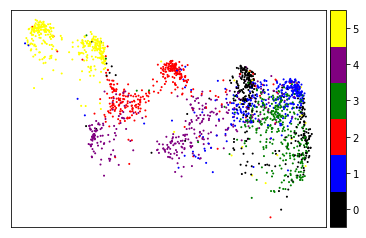

In [39]:
for n_neighbors in [2, 3, 5, 7, 10, 15, 20, 30]:
    print(f"n_neighbors = {n_neighbors}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    reducer.fit(X_scaled)

    embedding = reducer.transform(X)

#     plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=1)
# #     plt.xlim((2, 7))
# #     plt.ylim((-31, -25))
#     plt.show()
    
    fig, ax = plt.subplots()
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['black', 'blue', 'red', 'green', 'purple', 'yellow'])
    bounds = np.linspace(y.min() - 0.5, y.max() + 0.5, len(np.unique(y)) + 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=y, s=1, cmap=cmap, norm=norm)

    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.get_figure().colorbar(sc, cax=cax, ticks=[0, 1, 2, 3, 4, 5])

    fig.savefig(f'synthetic_vis_umap_n_neighbors={n_neighbors}.png')
    plt.show()

# Run MLP using results of ICA through Grid Search

In [26]:
pipe = Pipeline([('scaler', StandardScaler()),
                  (dim_red_name, umap.UMAP(n_neighbors=5, random_state=random_state)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (6, ), (10, ), (15,)]
param_grid = {f'{dim_red_name}__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=3, return_train_score=True, 
                  n_jobs=n_jobs)

In [27]:
gs.fit(X, y)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  5.0min finished
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False i

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('umap', UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=5, n...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'umap__n_components': [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40], 'mlp__hidden_layer_sizes': [(2,), (6,), (10,), (15,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [28]:
joblib.dump(gs, casename + "_gs.pkl")

['synthetic_umap_gs.pkl']

In [29]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('umap', UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=13, n_epochs=None,
   n_neighbors=5, ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [30]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

In [31]:
results.loc[:, ["param_mlp__hidden_layer_sizes", f"param_{dim_red_name}__n_components", "mean_test_score", "mean_train_score"]]

,param_mlp__hidden_layer_sizes,param_umap__n_components,mean_test_score,mean_train_score
0,"(2,)",2,0.6060,0.772644
1,"(2,)",3,0.6725,0.870751
2,"(2,)",4,0.6830,0.889736
3,"(2,)",5,0.6845,0.897490
4,"(2,)",13,0.5975,0.757562
5,"(2,)",23,0.7005,0.928993
6,"(2,)",27,0.6510,0.839546
7,"(2,)",30,0.7175,0.945747
8,"(2,)",32,0.6790,0.892694
9,"(2,)",35,0.5625,0.733675


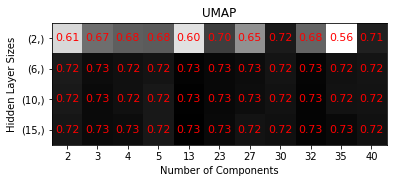

In [47]:
x_variable = f"param_{dim_red_name}__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results, x_variable, y_variable, z_variable, fontsize=11, title=f'{dim_red_name.upper()}', xlabel='Number of Components', ylabel='Hidden Layer Sizes',  savefig=f'{casename}_gs.png')

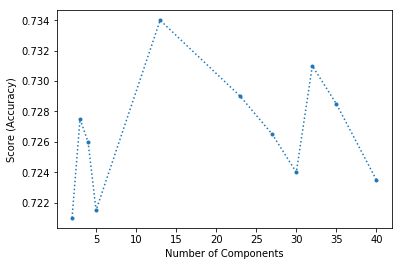

In [45]:
x_variable = f"param_{dim_red_name}__n_components"
z_variable = "mean_test_score"
best_scores = get_max_along_df_axis(results, z_variable, x_variable)
fig, ax = plt.subplots()
ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label=f'MLP fit on {dim_red_name.upper()}')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
plt.show()